L'énoncé du problème du Vehicle Routing Problem (VRP) avec une flotte de véhicules N80 K10 et la 
prédiction de la demande client par réseaux de neurones (ANN) est complexe. Voici un plan détaillé pour 
résoudre ce problème en utilisant l'algorithme de colonies de fourmis (ACO) avec une interface utilisateur 
interactive pour les paramètres. 



# 1. Prédictions de la demande client par ANN 

### Entrainement de data

In [1]:
#imports
import pandas as pd
import os 
import sweetviz as sv
import missingno as msno
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input , Dropout

from matplotlib import image as mpimg
from sklearn.preprocessing import LabelEncoder






In [2]:
#import historical Product Data 
df = pd.read_csv(r'data.csv')  # Adjust the path based on your actual structure STR404

In [10]:
df.head(100)

,Product_Code,Product_Category,Date,Order_Demand
0,982,27,2012-07-27,100.0
1,968,27,2012-01-19,500.0
2,968,27,2012-02-03,500.0
3,968,27,2012-02-09,500.0
4,968,27,2012-03-02,500.0
...,...,...,...,...
95,1501,18,2012-06-15,30000.0
96,1501,18,2012-06-20,30000.0
97,1501,18,2012-07-04,30000.0
98,1263,18,2012-06-19,1000.0


                                             |                                             | [  0%]   00:00 ->…


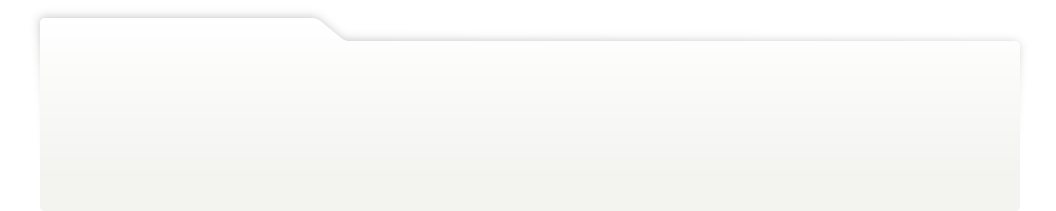
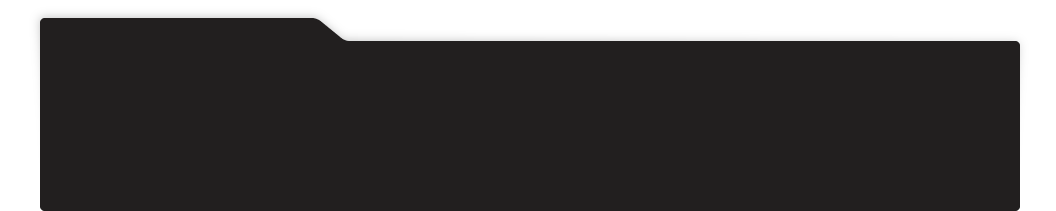
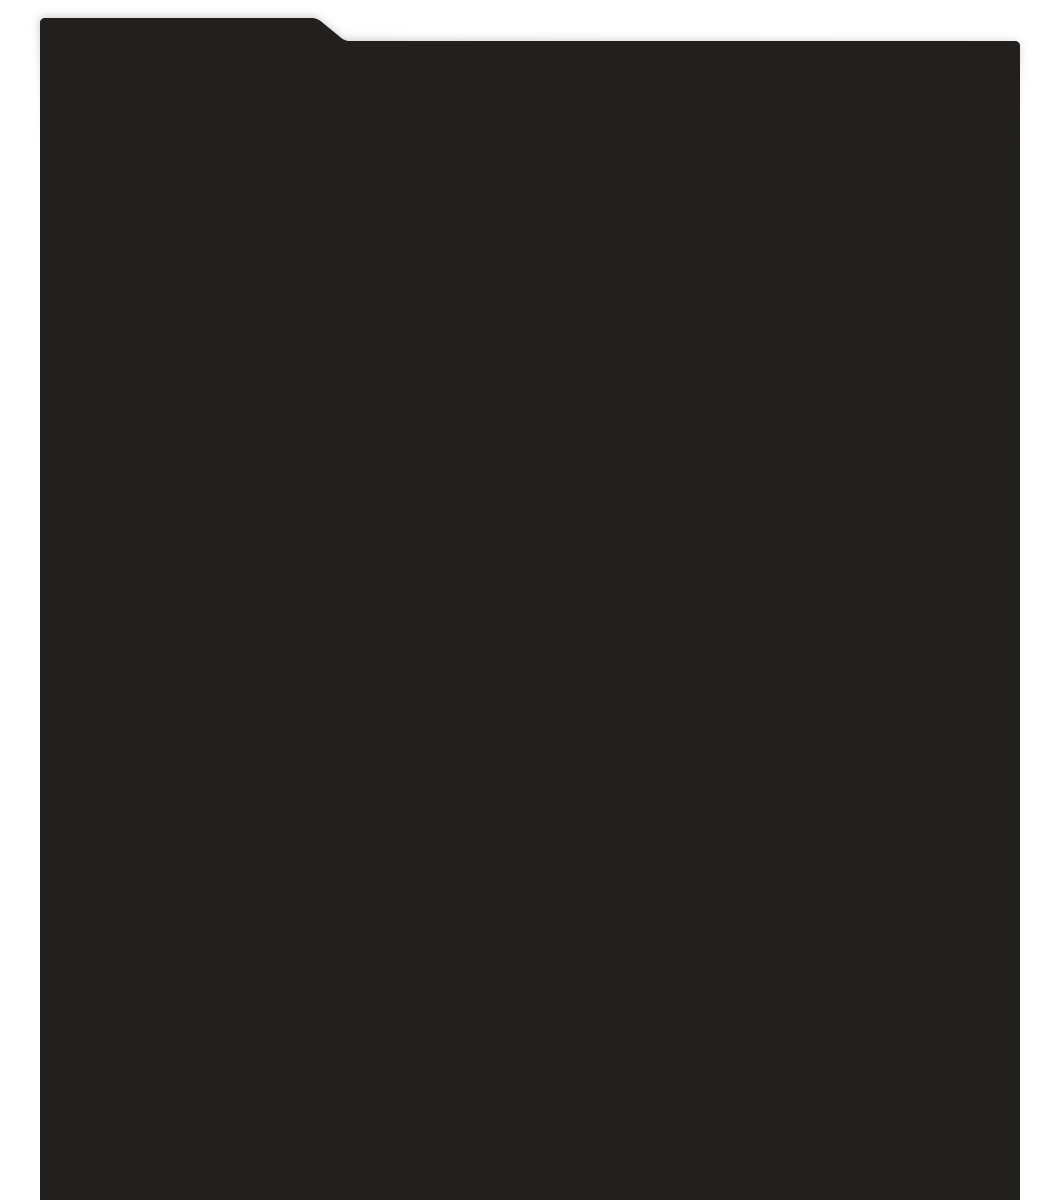
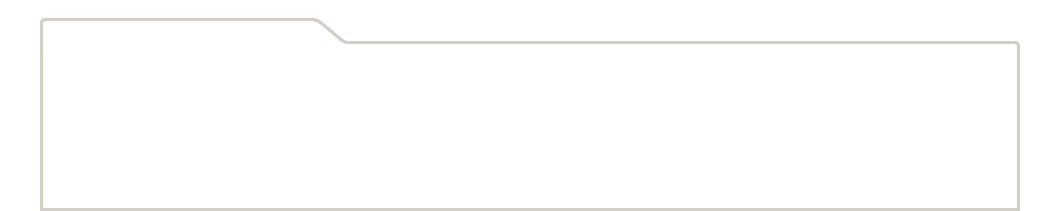
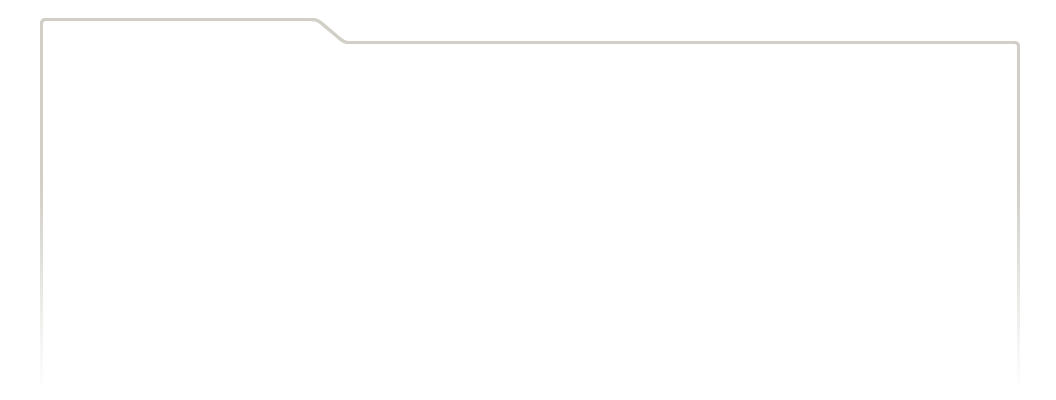
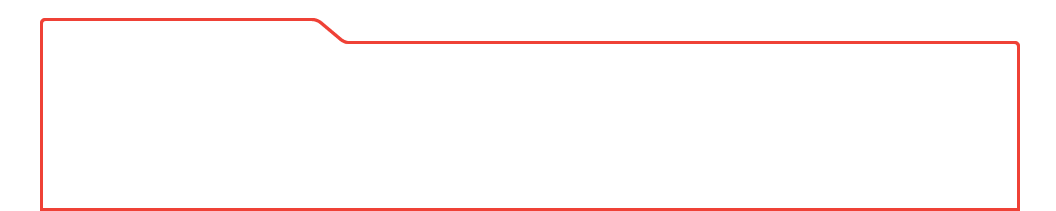
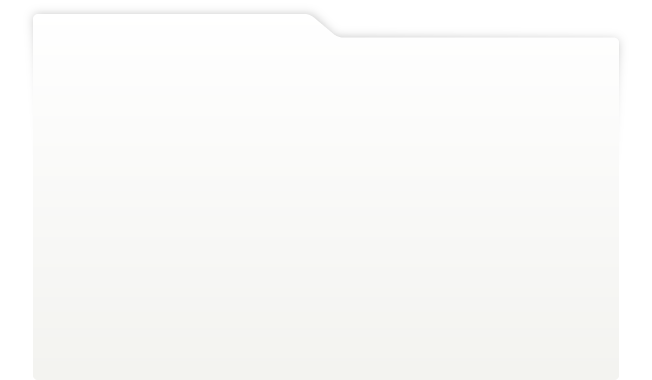
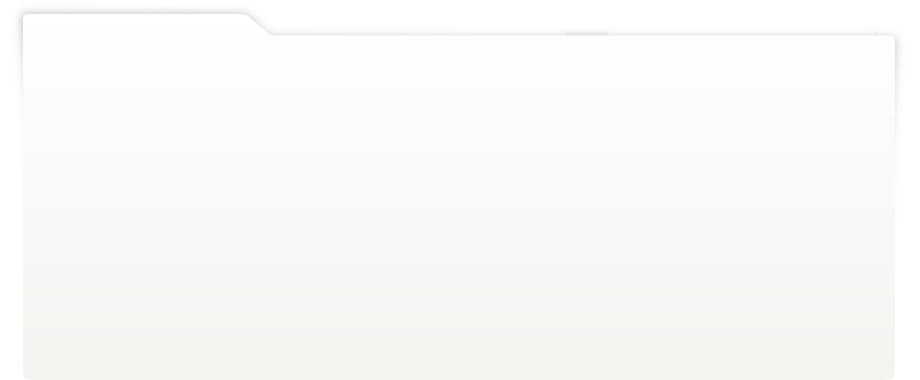
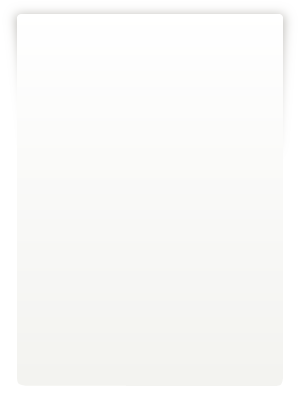
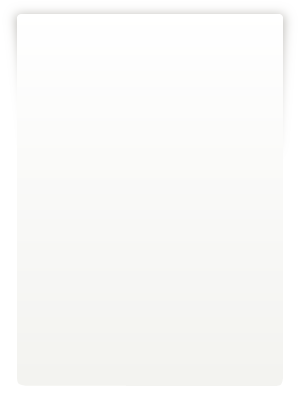
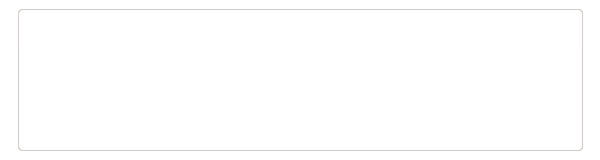
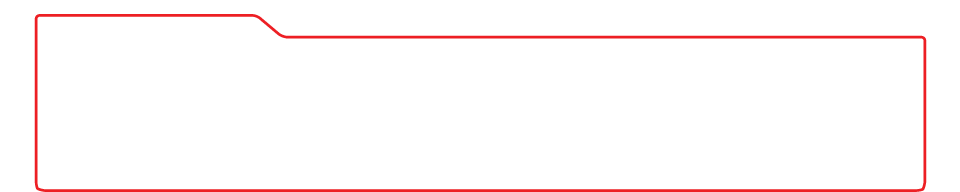
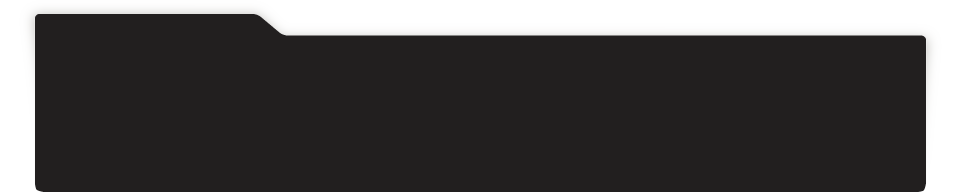
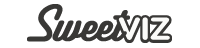
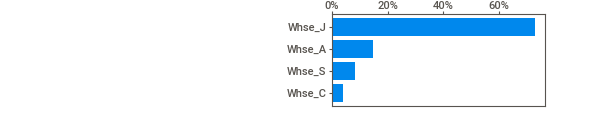
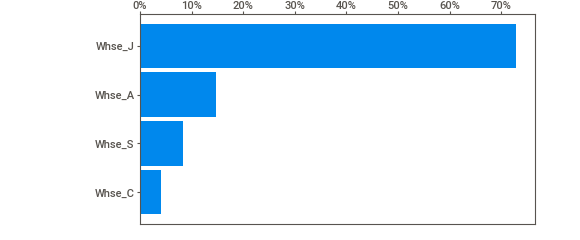
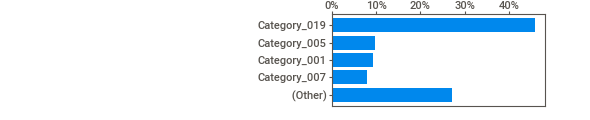
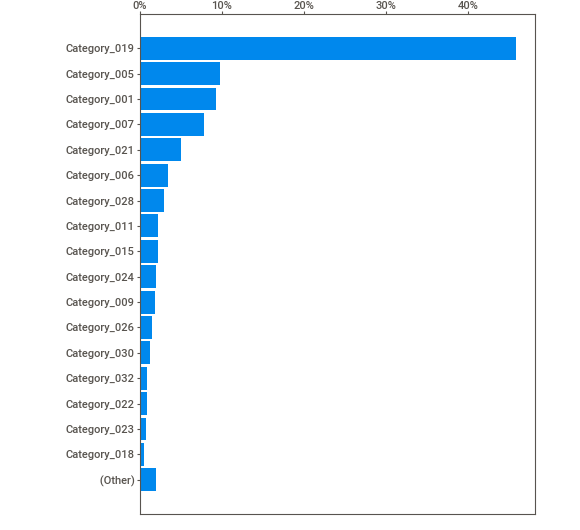
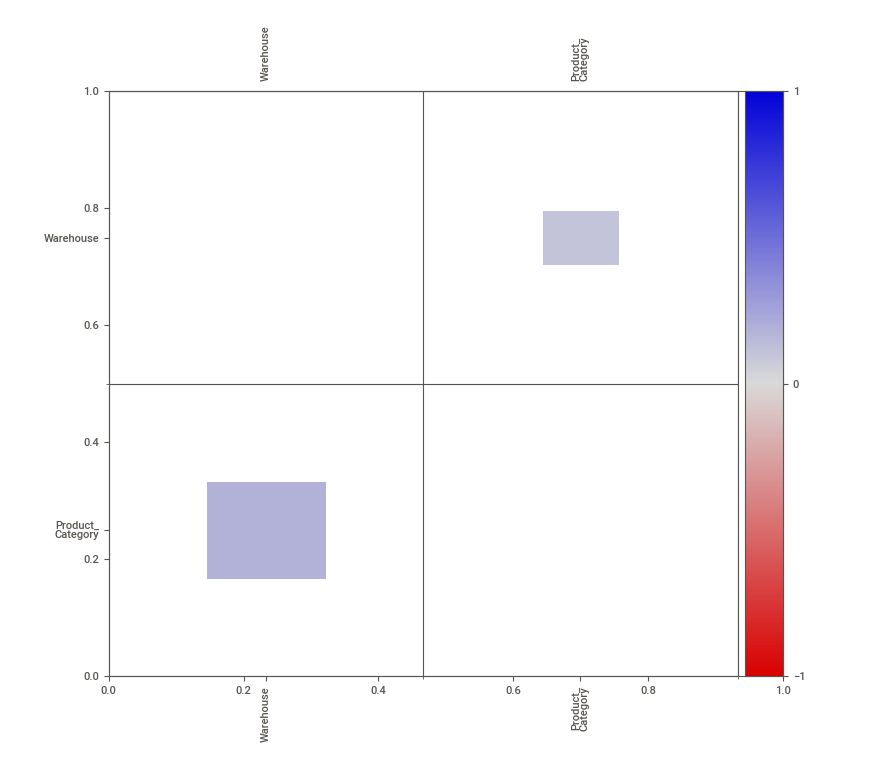
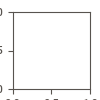

FileNotFoundError: [Errno 2] No such file or directory: 'VRP/OverviewSTR404.html'

In [4]:
# Generate the report
report = sv.analyze(df)
# To display the report in a Jupyter Notebook:
report.show_notebook()
# To save the report as an HTML file:
report.show_html(r'VRP/OverviewSTR404.html')

based on the previous we can conclude that there's no missing data 
for sake of simplicity we will delete warehouses as if we are having one warehouse and we will take into the account 
not only two years but from 2012 to 2016 

<Axes: >

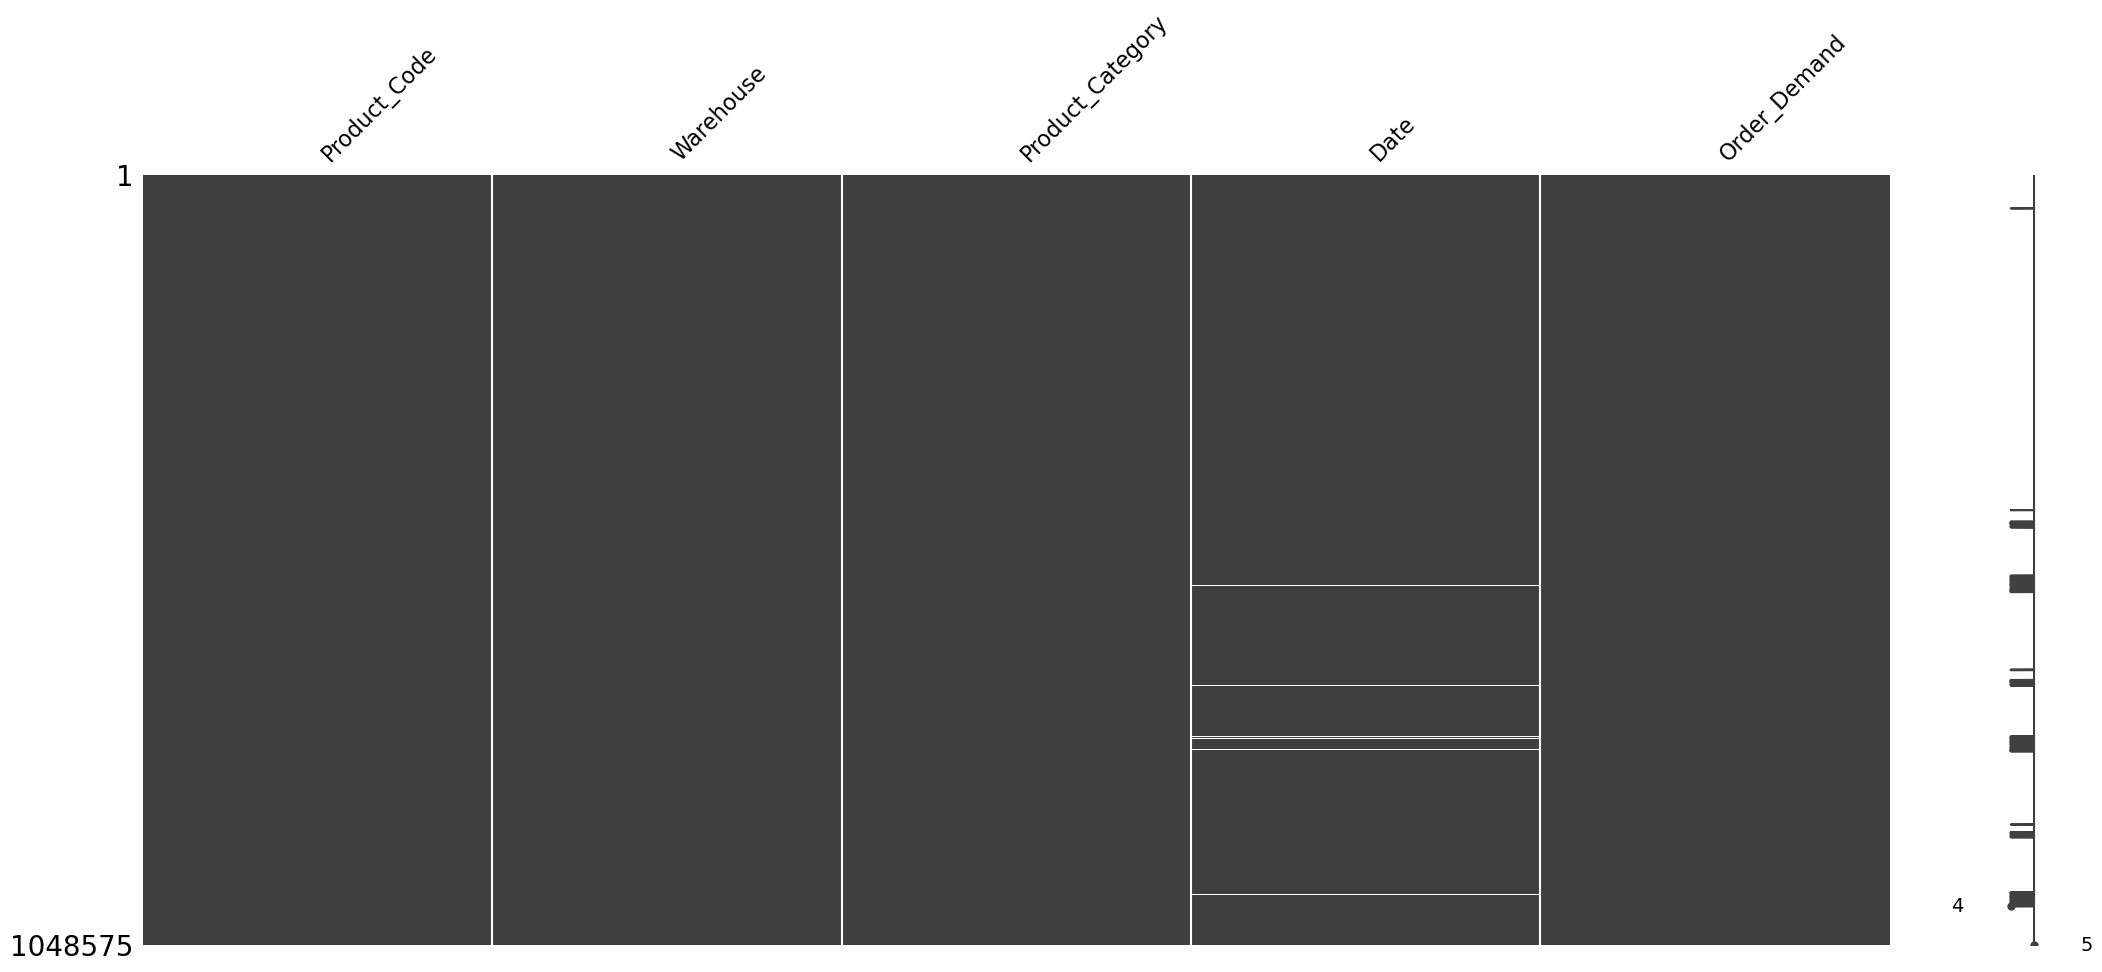

In [4]:
#look for missing data
msno.matrix(df)

As we can see there's not much missing except for some on the part of date 

In [5]:
#to drop missing values (which we don't have on our case)
df.dropna()


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


In [6]:
# delete warehouse :
df = df.drop(columns=['Warehouse'])
df.head()

,Product_Code,Product_Category,Date,Order_Demand
0,Product_0993,Category_028,2012/7/27,100
1,Product_0979,Category_028,2012/1/19,500
2,Product_0979,Category_028,2012/2/3,500
3,Product_0979,Category_028,2012/2/9,500
4,Product_0979,Category_028,2012/3/2,500


In [7]:
print(df['Order_Demand'].dtype)  # Check the column type

df['Order_Demand'] = pd.to_numeric(df['Order_Demand'], errors='coerce')  # Converts to int/float

order = df['Order_Demand'].to_numpy()

# Using Python built-in functions
min_order = min(order)
max_order = max(order)

print("Minimum Order Amount:", min_order)
print("Maximum Order Amount:", max_order)

object
Minimum Order Amount: 0.0
Maximum Order Amount: 4000000.0


In [8]:
# let's relabel some of them                                                                      STR404
# Initialize label encoders
product_encoder = LabelEncoder()
category_encoder = LabelEncoder()

# Apply encoding
df['Product_Code'] = product_encoder.fit_transform(df['Product_Code'])

df['Product_Category'] = category_encoder.fit_transform(df['Product_Category'])


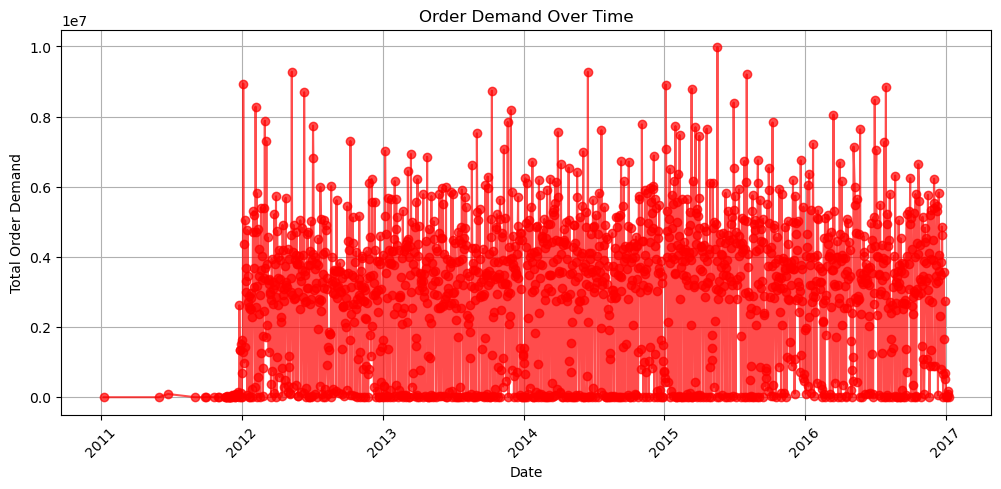

In [9]:

def plot_order_demand_over_time(df): 
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Convert date column
    date_demand = df.groupby("Date")["Order_Demand"].sum()  # Aggregate by date

    plt.figure(figsize=(12, 5))
    plt.plot(date_demand.index, date_demand.values, marker='o', linestyle='-', color='red', alpha=0.7)
    plt.title("Order Demand Over Time")
    plt.xlabel("Date")
    plt.ylabel("Total Order Demand")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()
    #STR404

# Call the function
plot_order_demand_over_time(df)

The order demand fluctuates significantly over time.
There is a huge increase in demand after 2012, meaning either:
Business growth or product popularity increased.
Data collection became more consistent.
New products or clients entered the market.
The high variation suggests seasonal trends or occasional spikes in demand.

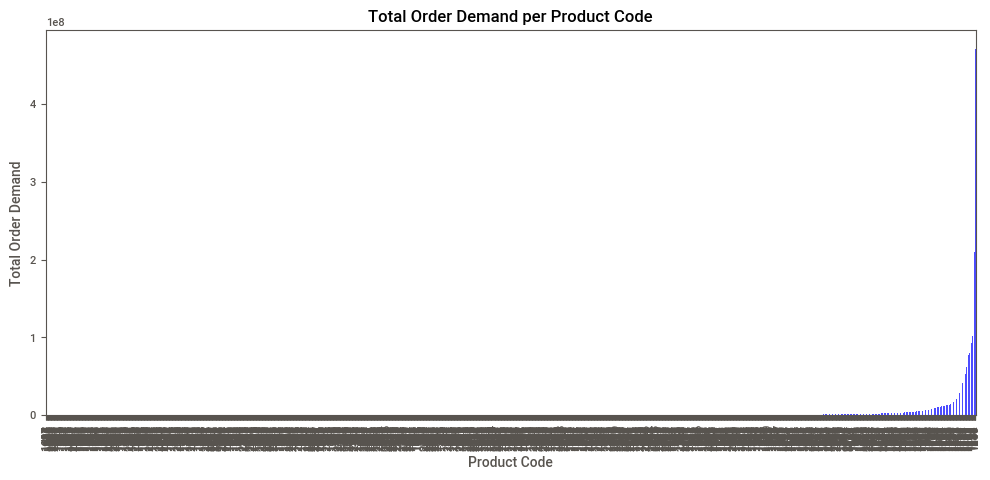

In [10]:
def plot_order_demand_per_product(df):
    product_demand = df.groupby("Product_Code")["Order_Demand"].sum().sort_values()

    plt.figure(figsize=(12, 5))
    product_demand.plot(kind='bar', color='blue', alpha=0.7)
    plt.title("Total Order Demand per Product Code")
    plt.xlabel("Product Code")
    plt.ylabel("Total Order Demand")
    plt.xticks(rotation=90)
    plt.show()


# Call the function
plot_order_demand_per_product(df)


only a few product codes have extreme demand.
Many products have low or negligible demand.

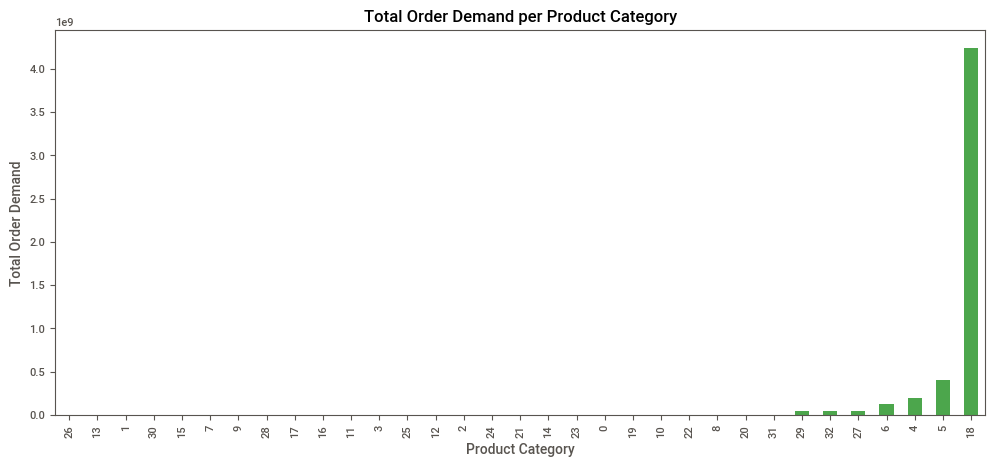

In [11]:
def plot_order_demand_per_category(df):
    category_demand = df.groupby("Product_Category")["Order_Demand"].sum().sort_values()

    plt.figure(figsize=(12, 5))
    category_demand.plot(kind='bar', color='green', alpha=0.7)
    plt.title("Total Order Demand per Product Category")
    plt.xlabel("Product Category")
    plt.ylabel("Total Order Demand")
    plt.xticks(rotation=90)
    plt.show()

# Call the function
plot_order_demand_per_category(df)


Some product categories have way higher demand than others.
**Category_019** dominates, meaning:
It is the **best-selling** or most frequently ordered category.
Other categories contribute far less to total demand.

## Normalizing Data

In [11]:
scaler = MinMaxScaler()
df['Order_Demand'] = scaler.fit_transform(df[['Order_Demand']])

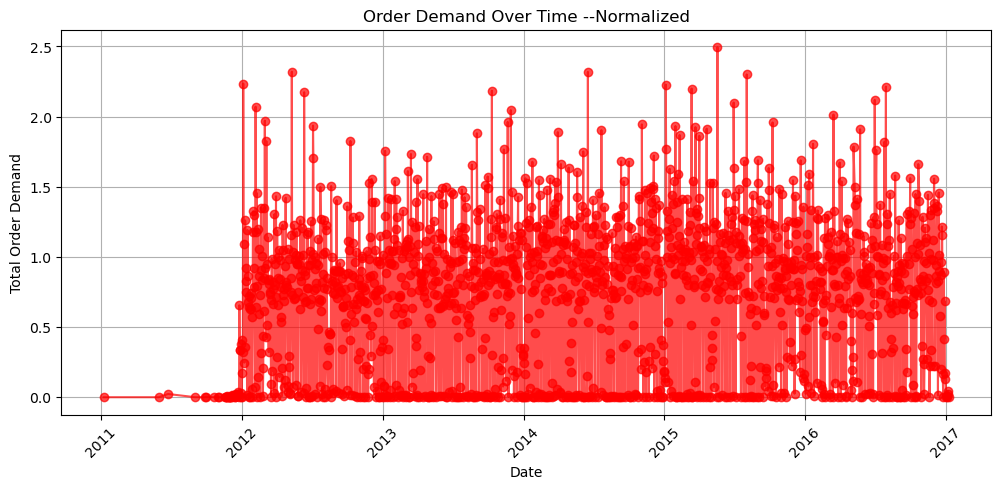

In [12]:

def plot_order_demand_over_time(df):
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Convert date column
    date_demand = df.groupby("Date")["Order_Demand"].sum()  # Aggregate by date

    plt.figure(figsize=(12, 5))
    plt.plot(date_demand.index, date_demand.values, marker='o', linestyle='-', color='red', alpha=0.7)
    plt.title("Order Demand Over Time --Normalized")
    plt.xlabel("Date")
    plt.ylabel("Total Order Demand")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Call the function
plot_order_demand_over_time(df)

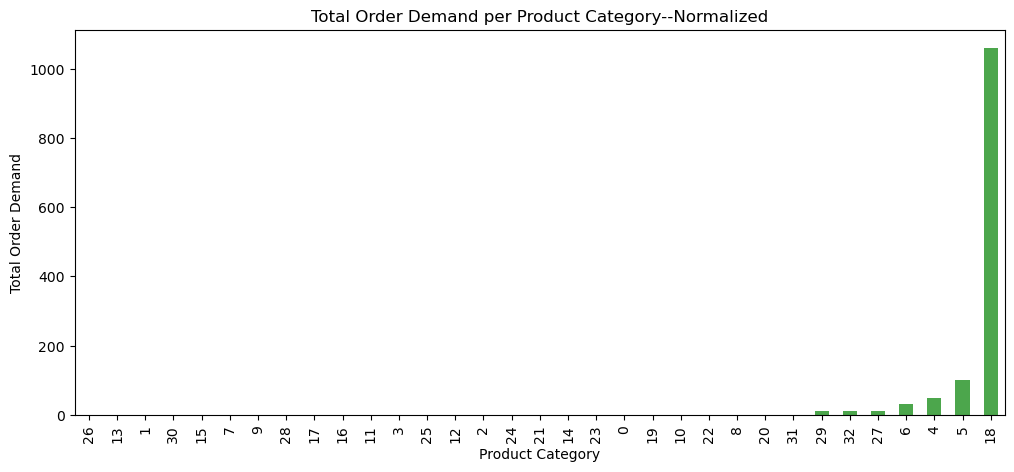

In [13]:
def plot_order_demand_per_category(df):
    category_demand = df.groupby("Product_Category")["Order_Demand"].sum().sort_values()

    plt.figure(figsize=(12, 5))
    category_demand.plot(kind='bar', color='green', alpha=0.7)
    plt.title("Total Order Demand per Product Category--Normalized")
    plt.xlabel("Product Category")
    plt.ylabel("Total Order Demand")
    plt.xticks(rotation=90)
    plt.show()

# Call the function
plot_order_demand_per_category(df)


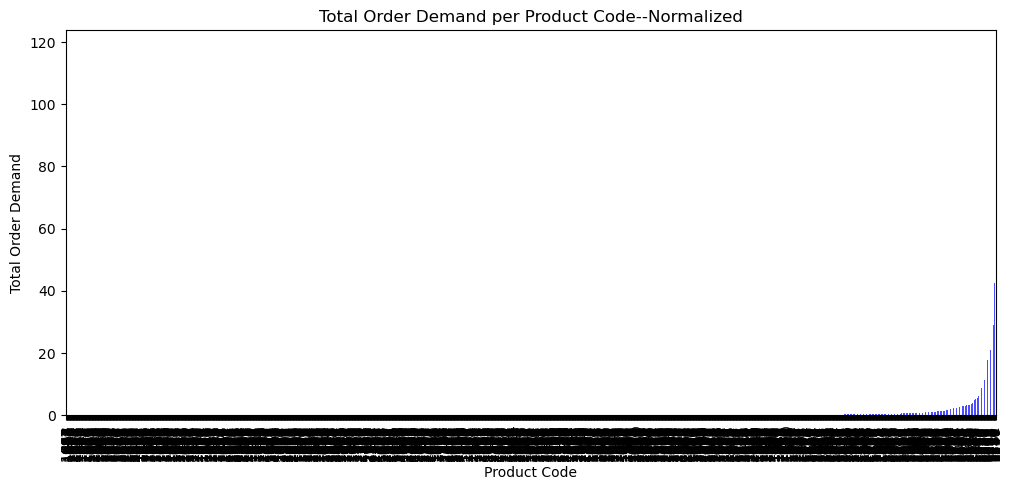

In [14]:
def plot_order_demand_per_product(df):
    product_demand = df.groupby("Product_Code")["Order_Demand"].sum().sort_values()

    plt.figure(figsize=(12, 5))
    product_demand.plot(kind='bar', color='blue', alpha=0.7)
    plt.title("Total Order Demand per Product Code--Normalized")
    plt.xlabel("Product Code")
    plt.ylabel("Total Order Demand")
    plt.xticks(rotation=90)
    plt.show()


# Call the function
plot_order_demand_per_product(df)


### Now we can tell they are further normalized


# Building the ANN to predict how much demand there's on certain dates

In [15]:
# Splitting Data
df_daily = df.groupby("Date", as_index=False)["Order_Demand"].sum()
df_daily = df_daily.sort_values(by="Date")

# Sort data by date (to maintain time sequence)
df_daily=df_daily.sort_values(by="Date")
df_daily['Order_Demand'] = np.log1p(df_daily['Order_Demand'])  # log(1 + x) prevents log(0) issues


# Define training period (e.g., last 3 years for training)
split_date = "2015-06-01"  # Adjust based on dataset range
# Split into train and test sets based on date
train_data = df_daily[df_daily["Date"] < split_date]
test_data = df_daily[df_daily["Date"] >= split_date]

print(f"Training data size: {train_data.shape}")
print(f"Testing data size: {test_data.shape}")


train_data.head(1213)

Training data size: (1213, 2)
Testing data size: (516, 2)


,Date,Order_Demand
0,2011-01-08,4.999999e-07
1,2011-05-31,2.699964e-05
2,2011-06-24,2.273949e-02
3,2011-09-02,3.124512e-04
4,2011-09-27,6.999976e-06
...,...,...
1208,2015-05-26,7.703951e-01
1209,2015-05-27,5.580523e-01
1210,2015-05-28,6.548386e-01
1211,2015-05-29,7.044555e-01


In [17]:
def create_time_series_features(data, target_col='Order_Demand', lags=30):
    """
    Create lag features for time series forecasting
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Input data containing the target column
    target_col : str
        Name of the target column to create lags from
    lags : int
        Number of lag features to create
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with added lag features
    """
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df

# Create features
train_data = create_time_series_features(train_data)
test_data = create_time_series_features(test_data)

# Remove NaN values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Separate features and target
feature_columns = [col for col in train_data.columns if col.startswith('lag_')]
X_train = train_data[feature_columns]
y_train = train_data['Order_Demand']
X_test = test_data[feature_columns]
y_test = test_data['Order_Demand']

# Convert to numeric types
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)
#STR404
# Convert to numpy arrays if needed
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

print(f"Training feature shape: {X_train.shape}")
print(f"Testing feature shape: {X_test.shape}")

Training feature shape: (1153, 30)
Testing feature shape: (456, 30)


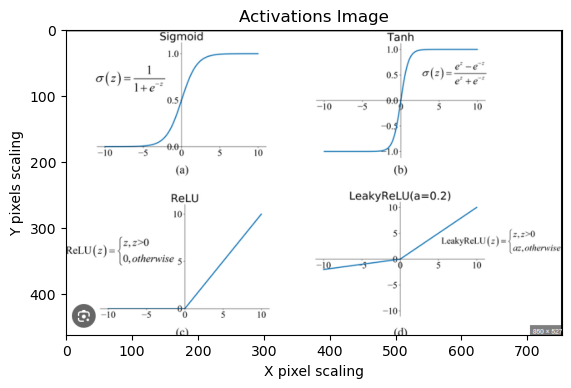

In [18]:
 
plt.title("Activations Image")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")
 
image = mpimg.imread(r'Activation.png')
plt.imshow(image)
plt.show()

In [17]:
# Train ANN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

model = Sequential([

    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),  
    Dense(256, activation='relu'),
    Dropout(0.3),  # Prevent overfitting
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  

])
# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,  # Start with a learning rate of 0.001
    decay_steps=1000,  # Apply decay every 1000 steps
    decay_rate=0.95,  # Reduce learning rate by 5% each step
    staircase=True  # Apply stepwise reduction
)

# Apply to Adam optimizer
optimizer = Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(optimizer=optimizer, loss="mse", metrics=['mae'])



In [18]:
#train the model
# Train model
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)
print(type(X_train))  # Should be <class 'pandas.DataFrame.STR404'>
 # Should be numerical (float or int)


history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test), verbose=1)


<class 'numpy.ndarray'>
Epoch 1/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0734 - mae: 0.2118 - val_loss: 0.0420 - val_mae: 0.1613
Epoch 2/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0295 - mae: 0.1358 - val_loss: 0.0438 - val_mae: 0.1697
Epoch 3/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0251 - mae: 0.1225 - val_loss: 0.0365 - val_mae: 0.1468
Epoch 4/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0230 - mae: 0.1138 - val_loss: 0.0373 - val_mae: 0.1473
Epoch 5/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0222 - mae: 0.1138 - val_loss: 0.0384 - val_mae: 0.1488
Epoch 6/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0231 - mae: 0.1154 - val_loss: 0.0378 - val_mae: 0.1475
Epoch 7/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0197 - mae: 0.1017 - val_loss: 0.0383 - val_mae: 0.1515
Epoch 8/1000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0192 - mae: 0.0998 - val_loss: 0.0364 - val_mae: 0.1484
Epoch 9/1000
37/37 ━━━━━━━━━━━━

In [ ]:
# Evaluate model
mse = model.evaluate(X_test, y_test)
print(f"Test MSE: {mse}")

In [ ]:
# Extract MSE and MAE from the evaluation results
mse, mae = mse  # Unpack the list values STR404

# Convert MSE and MAE back to original scale
original_mse = scaler.inverse_transform([[mse]])[0, 0]
original_mae = scaler.inverse_transform([[mae]])[0, 0]

# Print results
print(f"Test MSE STR404 in original scale: {original_mse}")
print(f"Test MAE in original scale: {original_mae}")


In [ ]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 5))
plt.plot(y_test_original, label="Actual Demand", color="blue")
plt.plot(y_pred_original, label="Predicted Demand", color="red", linestyle="dashed")
plt.legend()
plt.title("Actual vs. Predicted Order Demand")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def predict_next_30_days(model, X_test, scaler):
    """
    Predicts the next 30 days of demand using the trained ANN model.
    """
    # Start with the last available test data row STR404
    last_30_days = X_test[-1].reshape(1, -1)  # Get last test input row
    future_predictions = []

    for _ in range(30):  # Predict for the next 30 days
        next_day_pred = model.predict(last_30_days)[0, 0]  # Predict next demand
        future_predictions.append(next_day_pred)  # Store the prediction

        # Shift input data (remove oldest, add newest prediction)
        last_30_days = np.roll(last_30_days, -1)  # Shift left
        last_30_days[0, -1] = next_day_pred  # Insert new prediction

    # Convert predictions back to the original scale
    future_predictions_original = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions_original

# Run the prediction function
future_demand = predict_next_30_days(model, X_test, scaler)

# Plot the future predictions
plt.figure(figsize=(12, 5))
plt.plot(future_demand, label="Predicted Demand (Next 30 Days)", color="red", linestyle="dashed")
plt.xlabel("Days Ahead")
plt.ylabel("Predicted Order Demand")
plt.title("Predicted Order Demand for the Next 30 Days")
plt.legend()
plt.grid()
plt.show()

# Print predicted values
print("Predicted Order Demand for Next 30 Days:\n", future_demand.flatten())


In [ ]:
# les 80 clients:
# # Création du graphe
G = nx.Graph()

# Ajout des nœuds (chaque client est un nœud)
for i in range(num_clients):
    G.add_node(i, pos=(np.random.rand() * 100, np.random.rand() * 100))  # Position aléatoire des clients

# Ajout des arêtes (liaisons entre clients avec poids = distance)
for i in range(num_clients):
    for j in range(i + 1, num_clients):  # Éviter les doublons
        G.add_edge(i, j, weight=distance_matrix[i, j])

# Récupérer les positions des nœuds
pos = nx.get_node_attributes(G, 'pos')

# Dessiner le graphe
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=300, font_size=8)

# Ajouter les poids (distances) sur les arêtes
edge_labels = {(i, j): f"{distance_matrix[i, j]} km" for i, j in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

plt.title("Graphe des Distances entre les Clients")
plt.show()

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# STEP 1: Predict demand using ANN (assuming ANN is already trained)
# ----------------------------------------
# Assume we have ANN demand predictions for each client for the next 30 days
predicted_demand = np.random.randint(100, 500, size=(80,))  # Simulated ANN output

# Normalize demand for ACO
normalized_demand = predicted_demand / max(predicted_demand)  # Scale between 0-1


# STEP 2: Generate Distance Matrix (VRP Input)
# ----------------------------------------
num_clients = 80
num_vehicles = 10
vehicle_capacity = 1000  # Max capacity of each vehicle
max_time = 30  # Max allowed delivery time

np.random.seed(42)
distance_matrix = np.random.randint(1, 100, (num_clients, num_clients))
np.fill_diagonal(distance_matrix, 0)  # No distance to self


# STEP 3: Modify ACO to Prioritize Demand-Based Routes
# ----------------------------------------
num_ants = 20
num_iterations = 100
evaporation_rate = 0.1
alpha = 1
beta = 2
Q = 100

pheromones = np.ones((num_clients, num_clients)) * 0.1  # Initialize pheromones

def aco_vrp_with_ann():
    global pheromones
    best_route = None
    best_cost = float('inf')

    for iteration in range(num_iterations):
        routes = []
        costs = []

        for ant in range(num_ants):
            route = [0]  # Start at the depot (client 0)
            visited = set(route)

            while len(visited) < num_clients:
                current = route[-1]

                # Modify probability using ANN demand predictions
                probabilities = (pheromones[current] ** alpha) * ((1 / distance_matrix[current]) ** beta)
                probabilities *= (normalized_demand + 0.1)  # Boost probability based on demand

                probabilities[list(visited)] = 0  # Avoid revisiting
                probabilities /= probabilities.sum()  # Normalize

                next_client = np.random.choice(range(num_clients), p=probabilities)
                route.append(next_client)
                visited.add(next_client)

            routes.append(route)
            total_distance = sum(distance_matrix[route[i], route[i+1]] for i in range(len(route)-1))
            costs.append(total_distance)

        best_index = np.argmin(costs)
        if costs[best_index] < best_cost:
            best_route = routes[best_index]
            best_cost = costs[best_index]

        pheromones *= (1 - evaporation_rate)  # Evaporate pheromones
        for i in range(len(best_route)-1):
            pheromones[best_route[i], best_route[i+1]] += Q / best_cost  # Reinforce best path

    return best_route, best_cost

# Run ACO with ANN predictions
optimal_route, optimal_cost = aco_vrp_with_ann()

# Display results
print("Optimized Route Using ANN Demand Predictions:", optimal_route)
print("Total Cost of Route:", optimal_cost)

# Visualize results
plt.figure(figsize=(10, 5))
plt.bar(range(len(predicted_demand)), predicted_demand, color='red', alpha=0.7)
plt.xlabel("Client ID")
plt.ylabel("Predicted Demand")
plt.title("Predicted Demand from ANN for VRP")
plt.show()


In [ ]:

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Simulated client positions (randomly placed on a map)
num_clients = 80
np.random.seed(42)
client_positions = {i: (np.random.rand() * 100, np.random.rand() * 100) for i in range(num_clients)}

# Example of an optimized route found by ACO
optimized_route = optimal_route

# Create a graph
G = nx.DiGraph()

# Add nodes (clients)
for client, pos in client_positions.items():
    G.add_node(client, pos=pos)

# Add edges (connections based on the optimized route)
edges = [(optimized_route[i], optimized_route[i+1]) for i in range(len(optimized_route)-1)]
G.add_edges_from(edges)

# Get positions for visualization
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="red", width=2, node_size=500, font_size=8)

# Highlight depot (starting point)
nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color="green", node_size=800, label="Depot")

plt.title("Optimized Vehicle Routing Plan (ACO + ANN Demand)")
plt.legend()
plt.show()



In [ ]:
import joblib  # or pickle
import tensorflow as tf

# Save the trained ANN model
model.save("ann_demand_prediction.h5")

# Save the data scaler (if used for normalization)
joblib.dump(scaler, "scaler.pkl")
